I chose a dataset of Bitcoin addresses linked to ransomware attacks because it combines the fields of cryptography and blockchain with cybersecurity, and i think that the cryptography is an interesting subject.
The dataset enables a good analysis of address features and their economic activity, detection of anomalies, building models to identify malicious addresses, and exploring behavioral patterns of ransomware attacks.
Also, since it's based on real cybersecurity research, the analysis feels practical and relevant to real-world scenarios.

System Stage:

File Name: BitcoinHeistData

File Source: The BitcoinHeist Ransomware Address Dataset was published on **Kaggle** by the user "sapere0", based on research by Tai et al.

Link to the data set: https://www.kaggle.com/datasets/sapere0/bitcoinheist-ransomware-dataset

Size: 224MB

Type: CSV

Number Of Lines: We will count it in using pandas later.

* The filename and file extension do not appear to be suspicious.


### Dataset Column Descriptions (BitcoinHeistData.csv)

- **address**: The Bitcoin wallet address that received money. These addresses are usually used by ransomware attackers.

- **year**: The year when the address was last active in the dataset.

- **day**: The day of the year (1 to 365) when the address appeared in the snapshot. Day 1 = Jan 1st, Day 365 = Dec 31st.

- **length**: Represents the number of "mixing rounds", how often coins were sent and received through new addresses.

- **weight**: Measures how much coin merging happened. If many small inputs were combined into one output, the weight will be high.

- **count**: Number of transactions that merged multiple sources of funds.

- **looped**: Number of full coin "loops", when coins were split, sent through different paths, and then merged back into one address. This can be a sign of laundering.

- **neighbors**: Number of other Bitcoin addresses that sent money to or received money from this address. High values suggest the address is part of a wider transaction network.

- **income**: Total amount of money received by the address, in satoshis (1 Bitcoin = 100 million satoshis). This shows how much ransom money was collected.

- **label**: The name of the ransomware family that used this address (`cryptolocker`, `cerber`, ...). If it says `white`, the address is not known to be ransomware.

* I found 1 version on kaggle.

### Meta Data:

In [3]:
import pandas as pd
import os
import re

# Extended phishing bait keywords
phishing_keywords = [
    "phish", "login", "bank", "account", "invoice", "paypal", "secure", "security", "verify", "update", "billing"]

# Regex patterns for leetspeak substitutions
leet_patterns = {
    "a": "[a@]",
    "e": "[e3]",
    "i": "[i1!|]",
    "o": "[o0]",
    "s": "[s5$]",
    "l": "[l1!|]",
    "t": "[t7+]",
    "ph": "(ph|f)",
}

# Function to turn keyword into a regex with leet support
def leetspeak_pattern(word):
    pattern = ""
    i = 0
    while i < len(word):
        # Special case for 'ph'
        if word[i:i+2] == "ph":
            pattern += leet_patterns["ph"]
            i += 2
        else:
            pattern += leet_patterns.get(word[i], word[i])
            i += 1
    return pattern

# Build regex for all phishing keywords
phishing_regexes = [re.compile(leetspeak_pattern(keyword), re.IGNORECASE) for keyword in phishing_keywords]

# Final filename red flag checker
def check_filename_red_flags(filename):
    red_flags = []

    name, ext = os.path.splitext(filename)

    # 1. Multiple extensions (e.g., invoice.pdf.exe)
    if filename.count('.') > 1:
        red_flags.append("Multiple dots (suspicious extensions)")

    # 2. Known phishing bait words with leetspeak
    for regex in phishing_regexes:
        if regex.search(filename):
            red_flags.append("Contains phishing-style name")

    # 3. Random character strings (hash-like)
    if re.fullmatch(r"[a-zA-Z0-9]{8,}", name) and not re.search(r"[aeiou]{2,}", name, re.IGNORECASE):
        red_flags.append("Random character string")

    # 4. Executable disguised as something else
    if filename.lower().endswith((".jpg.exe", ".png.exe", ".pdf.exe", ".docx.exe")):
        red_flags.append("Executable disguised as document or image")

    return red_flags

def check_size_per_row(filepath, min_bytes_per_row=20, max_bytes_per_row=10000):
    file_size = os.path.getsize(filepath)  # in bytes

    try:
        df = pd.read_csv(filepath)
        row_count = len(df)
        if row_count == 0:
            return "Empty file (0 rows)"

        size_per_row = file_size / row_count

        if size_per_row < min_bytes_per_row:
            return f"Too small: {size_per_row:.1f} bytes/row"
        elif size_per_row > max_bytes_per_row:
            return f"Too large: {size_per_row:.1f} bytes/row"
        else:
            return f"OK: {size_per_row:.1f} bytes/row"

    except Exception as e:
        return f"Error reading file: {e}"


# Optional: Show full float precision
pd.set_option('display.float_format', '{:.20f}'.format)

# Set the dataset folder path
folder_path = "Data Set"

# Loop over all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        print(f"\nProcessing file: {filename}")
        print("=" * 60)

        # Load CSV safely with float parsing
        try:
            df = pd.read_csv(file_path, index_col=False, dtype={'weight': float, 'income': float})
        except Exception as e:
            print(f"Failed to read {filename}: {e}")
            continue

        flags = check_filename_red_flags(filename)
        if flags:
            print(f"\nRed flags in filename: {filename}")
            for flag in flags:
                print(f"  - {flag}")
        else:
            print(f"\nNo name red flags found in filename: {filename}")

        result = check_size_per_row(file_path)
        print(f"File size check result: {result}")
        
        # Check for missing values
        print("\nMissing values per column:")
        print(df.isnull().sum())

        # Check data types
        print("\nData types:")
        print(df.dtypes)

        # Count unique values
        print("\nUnique values per column:")
        for col in df.columns:
            print(f"{col}: {df[col].nunique()} unique values")

        # Look for special values: -999 or 'unknown'
        print("\nChecking for special values (-999 or 'unknown'):")
        mask = (df == -999).any(axis=1) | (df.astype(str) == "unknown").any(axis=1)
        special_values = df[mask].copy()
        special_values["csv_row_number"] = special_values.index + 2

        print(f"Rows with special values: {len(special_values)}")

        # Display them (if any)
        if not special_values.empty:
            cols = ["csv_row_number"] + [col for col in special_values.columns if col != "csv_row_number"]
            special_values = special_values[cols]

            with pd.option_context('display.max_columns', None,
                                   'display.max_colwidth', None,
                                   'display.max_rows', None,
                                   'display.expand_frame_repr', False):
                display(special_values)

        # Check for zero income values
        if "income" in df.columns:
            zero_income = df[df["income"] == 0]
            print(f"\nAddresses with zero income: {len(zero_income)}")

        # Print total row count
        print(f"\nNumber of rows in the CSV file: {len(df)}")
        print("=" * 60)



Processing file: BitcoinHeistData.csv

No name red flags found in filename: BitcoinHeistData.csv
File size check result: OK: 80.9 bytes/row

Missing values per column:
address      0
year         0
day          0
length       0
weight       0
count        0
looped       0
neighbors    0
income       0
label        0
dtype: int64

Data types:
address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object

Unique values per column:
address: 2631095 unique values
year: 8 unique values
day: 365 unique values
length: 73 unique values
weight: 784927 unique values
count: 11572 unique values
looped: 10168 unique values
neighbors: 814 unique values
income: 1866365 unique values
label: 29 unique values

Checking for special values (-999 or 'unknown'):
Rows with special values: 4


,csv_row_number,address,year,day,length,weight,count,looped,neighbors,income,label
2566168,2566170,unknown,2017,345,144,146.13774144540099086953,5191,4812,1192,662525717815.00000000000000000000,white
2682857,2682859,unknown,2018,97,144,1827.77883521448006831633,4772,4772,7589,3097053880245.00000000000000000000,white
2807623,2807625,unknown,2018,221,144,1866.71672921494996444380,5680,5680,11746,10678161295882.00000000000000000000,white
2879952,2879954,unknown,2018,294,144,1943.74879331340002863726,3975,3975,12920,6510062177369.00000000000000000000,white



Addresses with zero income: 0

Number of rows in the CSV file: 2916697


### I will display some lines of the file "BitcoinHeistData.csv" to show an example.

In [4]:
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.00833333333333330026,1,0,2,100050000.00000000000000000000,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.00024414062500000000,1,0,1,100000000.00000000000000000000,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.00000000000000000000,1,0,2,200000000.00000000000000000000,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.00390625000000000000,1,0,2,71200000.00000000000000000000,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.07284840719899310368,456,0,1,200000000.00000000000000000000,princetonLocky


### Columns Distributions:

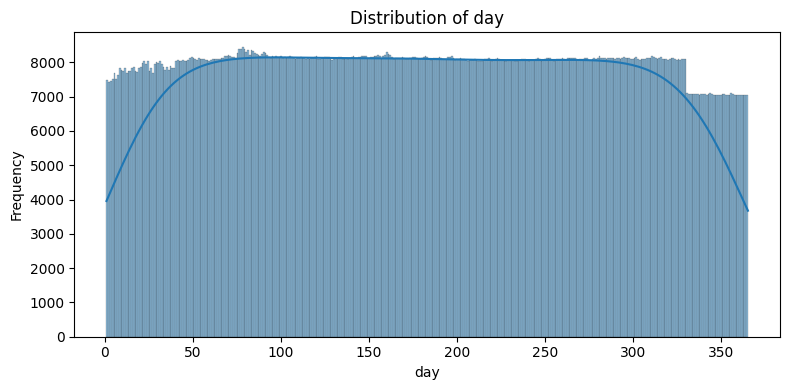

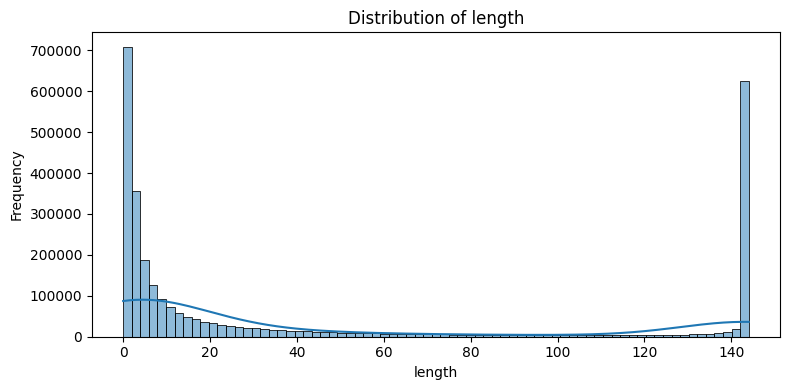

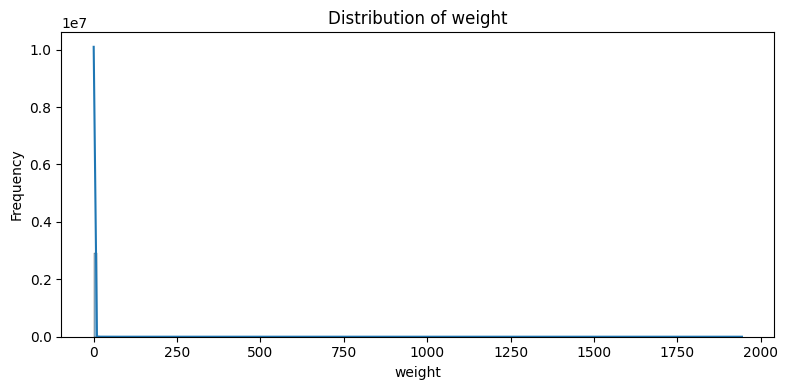

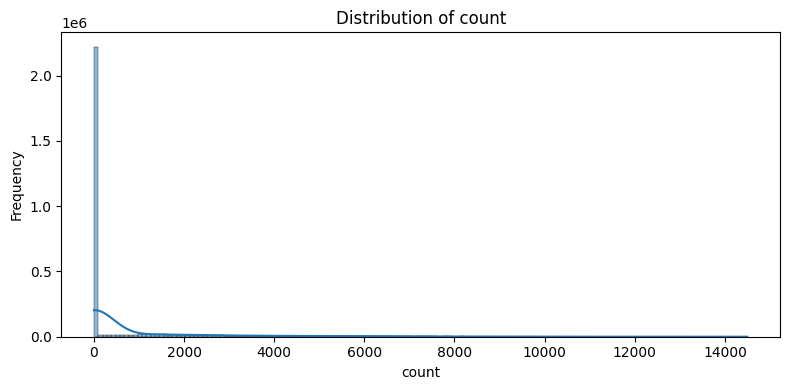

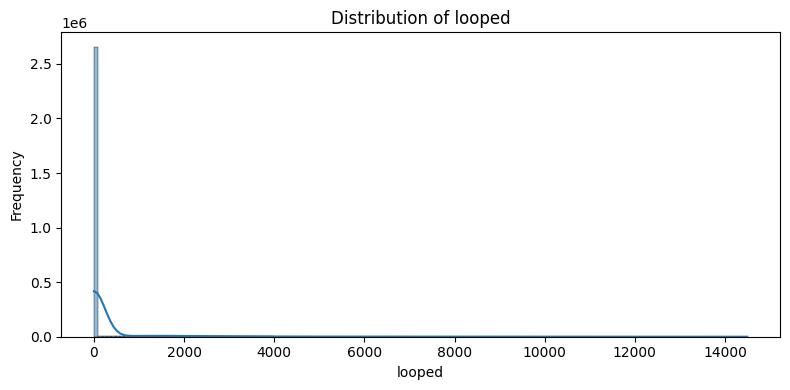

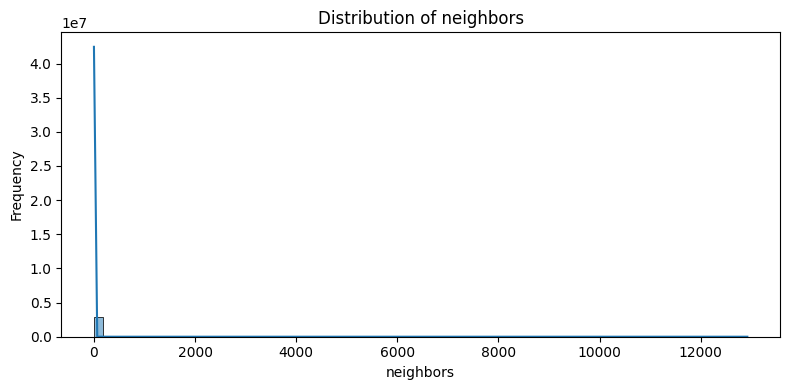

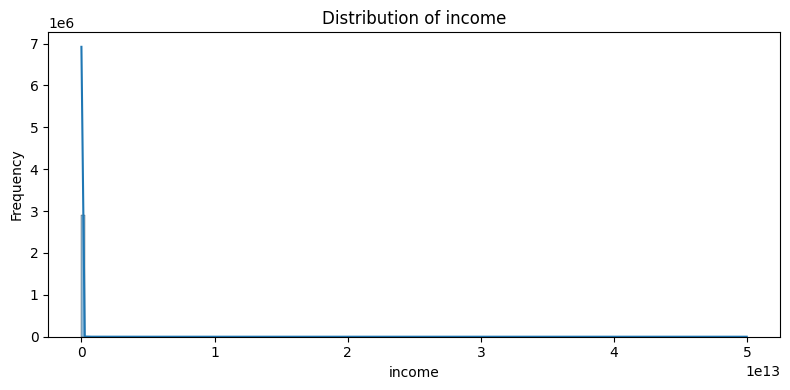

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(df, column, bins_num=100):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], bins=bins_num, kde=True, kde_kws={'bw_adjust': 5.0})
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_histogram(df, 'day', bins_num=365)
plot_histogram(df, 'length', bins_num=73)
plot_histogram(df, 'weight', bins_num=200)
plot_histogram(df, 'count', bins_num=150)
plot_histogram(df, 'looped', bins_num=150)
plot_histogram(df, 'neighbors', bins_num=75)
plot_histogram(df, 'income', bins_num=200)
    

### Statistic Detour:


Column: day
Mean: 181.46
Median: 181.00
Std: 104.01
Min: 1.00
Max: 365.00
Skewness: 0.01
Kurtosis: 1.81
Pearson Skewness: 0.01
IQR Outliers: 0
3*STD Outliers: 0
MAD Outliers: 0


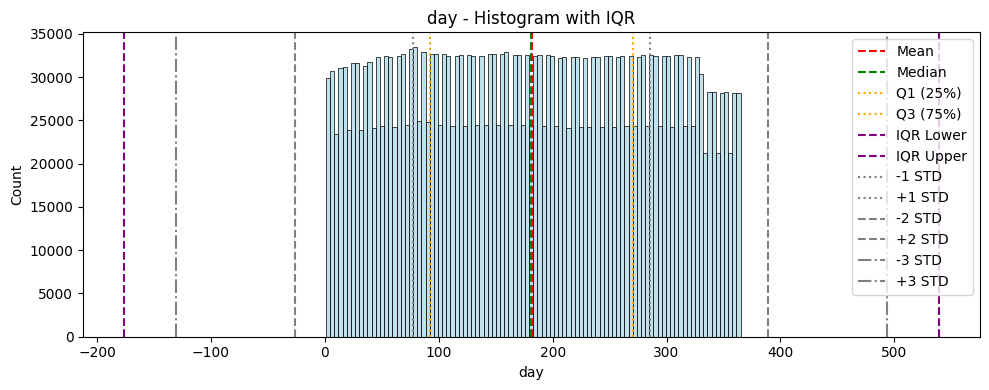

C:\Users\שרבל\AppData\Local\Temp\ipykernel_50572\2868400980.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


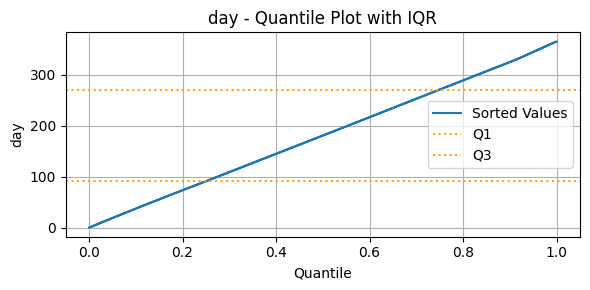


Column: length
Mean: 45.01
Median: 8.00
Std: 58.98
Min: 0.00
Max: 144.00
Skewness: 0.92
Kurtosis: 2.03
Pearson Skewness: 1.88
IQR Outliers: 0
3*STD Outliers: 0
MAD Outliers: 1009759


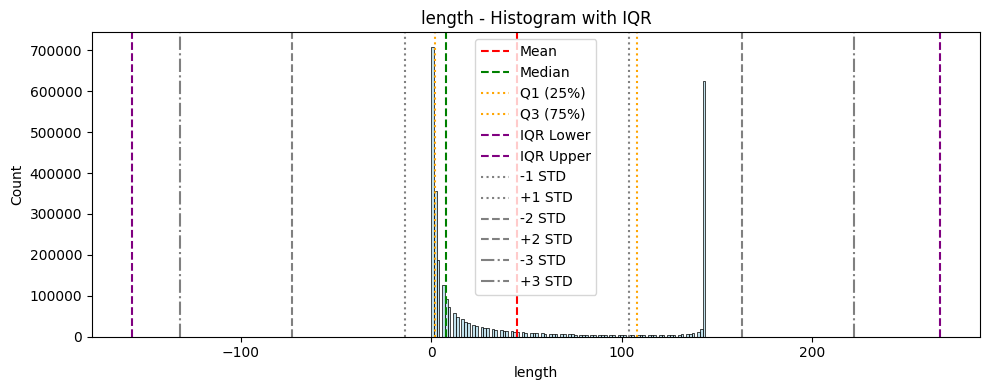

C:\Users\שרבל\AppData\Local\Temp\ipykernel_50572\2868400980.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


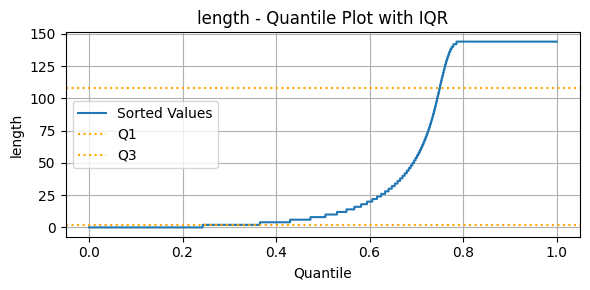


Column: weight
Mean: 0.55
Median: 0.25
Std: 3.67
Min: 0.00
Max: 1943.75
Skewness: 243.02
Kurtosis: 102691.79
Pearson Skewness: 0.24
IQR Outliers: 55006
3*STD Outliers: 5305
MAD Outliers: 717549


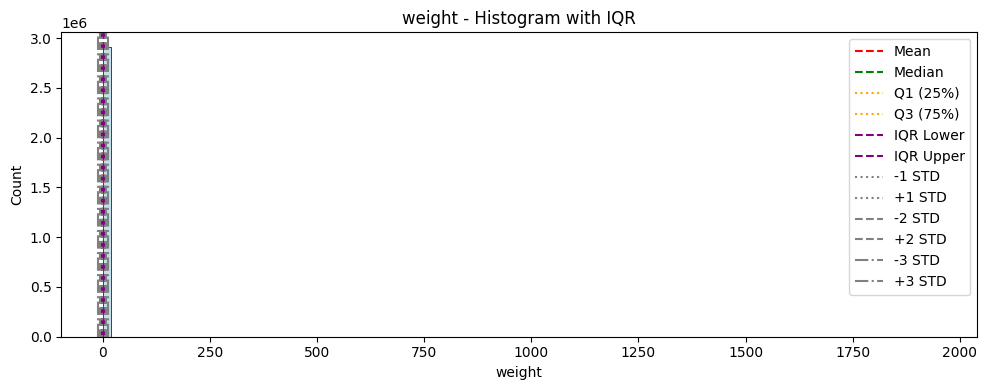

c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


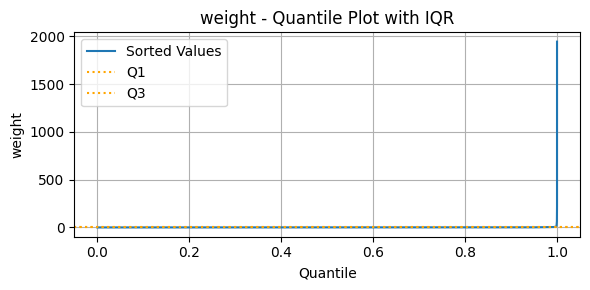


Column: count
Mean: 721.64
Median: 1.00
Std: 1689.68
Min: 1.00
Max: 14497.00
Skewness: 2.93
Kurtosis: 12.42
Pearson Skewness: 1.28
IQR Outliers: 688188
3*STD Outliers: 91373
MAD Outliers: 1243147


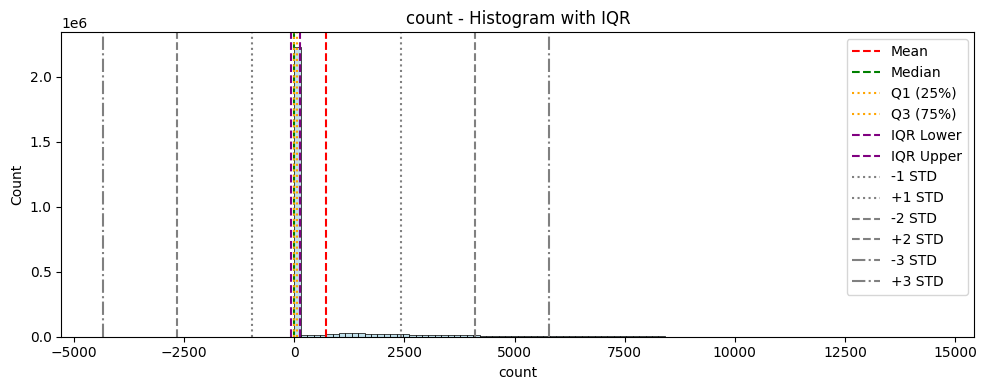

C:\Users\שרבל\AppData\Local\Temp\ipykernel_50572\2868400980.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


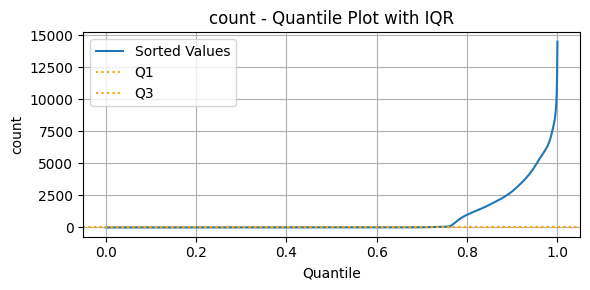


Column: looped
Mean: 238.51
Median: 0.00
Std: 966.32
Min: 0.00
Max: 14496.00
Skewness: 5.52
Kurtosis: 40.24
Pearson Skewness: 0.74
IQR Outliers: 411820
3*STD Outliers: 73748
MAD Outliers: 411820


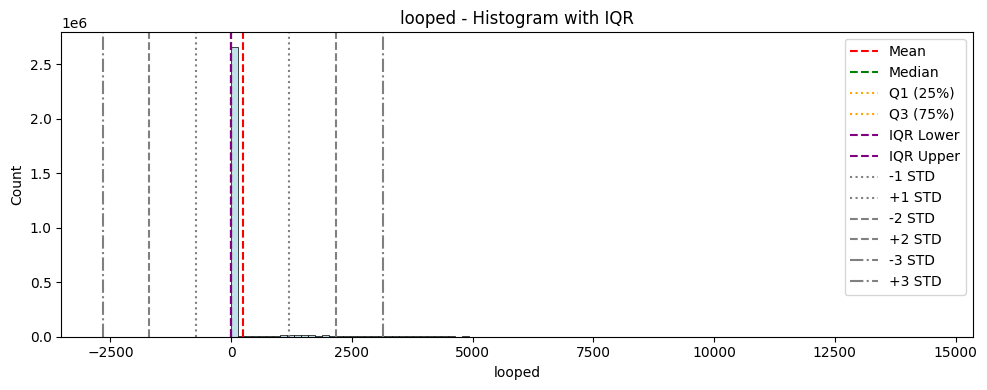

c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


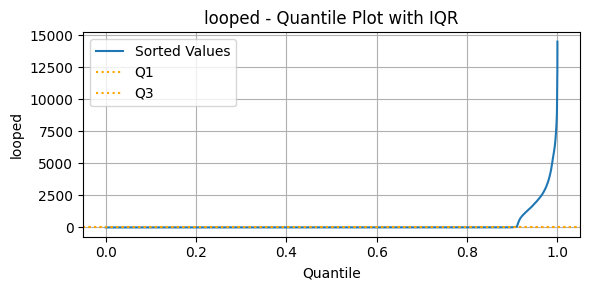


Column: neighbors
Mean: 2.21
Median: 2.00
Std: 17.92
Min: 1.00
Max: 12920.00
Skewness: 293.58
Kurtosis: 171458.60
Pearson Skewness: 0.03
IQR Outliers: 114659
3*STD Outliers: 3090
MAD Outliers: 1058413


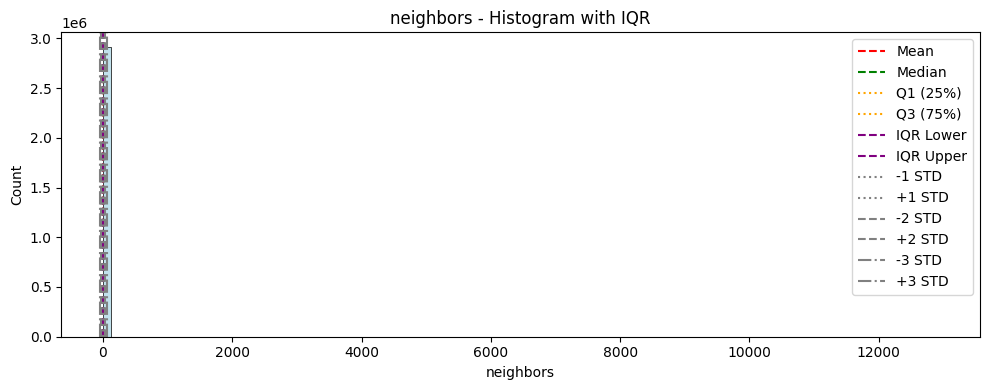

c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


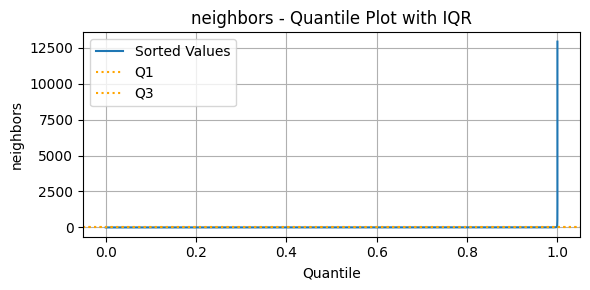


Column: income
Mean: 4464889007.19
Median: 199998518.00
Std: 162685932780.61
Min: 30000000.00
Max: 49964398238996.00
Skewness: 228.37
Kurtosis: 62541.32
Pearson Skewness: 0.08
IQR Outliers: 430677
3*STD Outliers: 2844
MAD Outliers: 872933


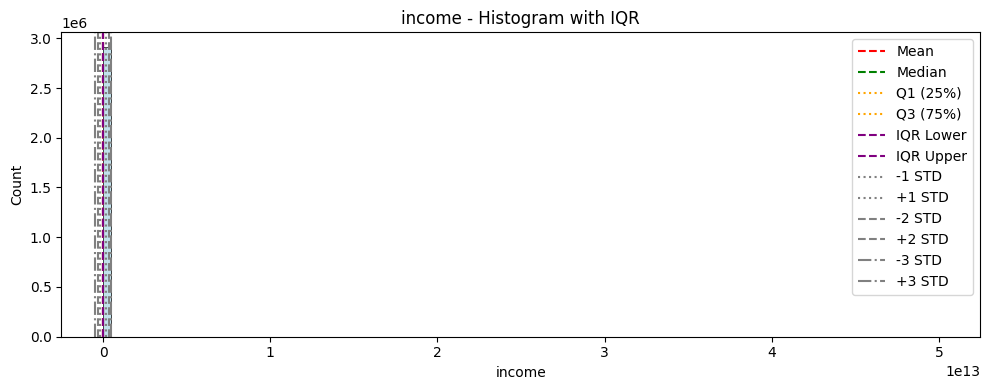

C:\Users\שרבל\AppData\Local\Temp\ipykernel_50572\2868400980.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


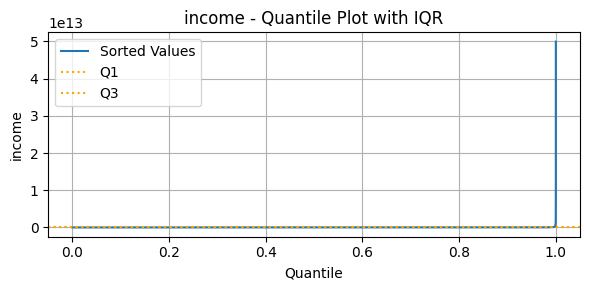


Most common address: 1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU (420 occurrences, 0.01%)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

# Columns to analyze
interested_cols = ['day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']

# Describe distribution and visualize
def describe_distribution(df, column):
    data = df[column].dropna()
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=0)

    print(f"\nColumn: {column}")
    print(f"Mean: {mean:.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Std: {std:.2f}")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")

    # Manual Skewness and Kurtosis
    skew = np.sum(((data - mean) / std) ** 3) / n
    kurtosis = np.sum(((data - mean) / std) ** 4) / n
    pearson_skew = 3 * (mean - data.median()) / std

    print(f"Skewness: {skew:.2f}")
    print(f"Kurtosis: {kurtosis:.2f}")
    print(f"Pearson Skewness: {pearson_skew:.2f}")

    # Quantiles
    quantiles = data.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

    # IQR Method
    Q1 = quantiles[0.25]
    Q3 = quantiles[0.75]
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR
    iqr_outliers = data[(data < lower_iqr) | (data > upper_iqr)]
    print(f"IQR Outliers: {len(iqr_outliers)}")

    # 3*STD Method
    lower_std = mean - 3 * std
    upper_std = mean + 3 * std
    std_outliers = data[(data < lower_std) | (data > upper_std)]
    print(f"3*STD Outliers: {len(std_outliers)}")

    # MAD Method
    median = data.median()
    mad = np.median(np.abs(data - median))
    lower_mad = median - 3 * mad
    upper_mad = median + 3 * mad
    mad_outliers = data[(data < lower_mad) | (data > upper_mad)]
    print(f"MAD Outliers: {len(mad_outliers)}")



    # Visualization
    # Histogram + KDE + IQR bounds
    plt.figure(figsize=(10, 4))
    sns.histplot(data, bins=100, color='lightblue')

    # Central tendency
    plt.axvline(mean, color='red', linestyle='--', label='Mean')
    plt.axvline(median, color='green', linestyle='--', label='Median')

    # IQR bounds
    plt.axvline(Q1, color='orange', linestyle=':', label='Q1 (25%)')
    plt.axvline(Q3, color='orange', linestyle=':', label='Q3 (75%)')
    plt.axvline(lower_iqr, color='purple', linestyle='--', label='IQR Lower')
    plt.axvline(upper_iqr, color='purple', linestyle='--', label='IQR Upper')

    # Standard deviation bounds
    plt.axvline(mean - std, color='gray', linestyle=':', label='-1 STD')
    plt.axvline(mean + std, color='gray', linestyle=':', label='+1 STD')
    plt.axvline(mean - 2 * std, color='gray', linestyle='--', label='-2 STD')
    plt.axvline(mean + 2 * std, color='gray', linestyle='--', label='+2 STD')
    plt.axvline(mean - 3 * std, color='gray', linestyle='-.', label='-3 STD')
    plt.axvline(mean + 3 * std, color='gray', linestyle='-.', label='+3 STD')

    plt.title(f"{column} - Histogram with IQR")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Quantile Plot
    plt.figure(figsize=(6, 3))
    data_sorted = np.sort(data)
    q_vals = np.linspace(0, 1, len(data_sorted))
    plt.plot(q_vals, data_sorted, label="Sorted Values")
    plt.axhline(Q1, color='orange', linestyle=':', label='Q1')
    plt.axhline(Q3, color='orange', linestyle=':', label='Q3')
    plt.title(f"{column} - Quantile Plot with IQR")
    plt.xlabel("Quantile")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run for each selected column=
for col in interested_cols:
    describe_distribution(df, col)

# Address mode info
address_mode = mode(df['address'])
address_mode_number = df['address'].value_counts().get(address_mode, 0)
address_mode_percentage = (address_mode_number / len(df)) * 100
print(f"\nMost common address: {address_mode} ({address_mode_number} occurrences, {address_mode_percentage:.2f}%)")



Column: weight
Mean: 0.55
Median: 0.25
Std: 3.67
Min: 0.00
Max: 1943.75
Skewness: 243.02
Kurtosis: 102691.79
Pearson Skewness: 0.24
IQR Outliers: 55006
3*STD Outliers: 5305
MAD Outliers: 717549


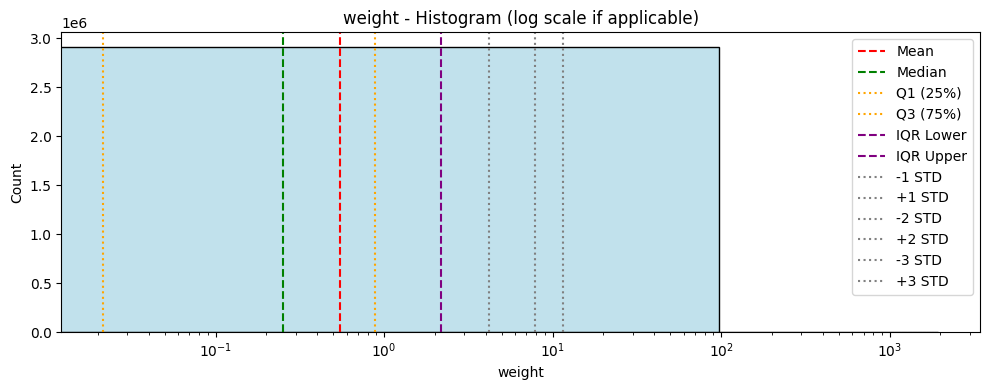

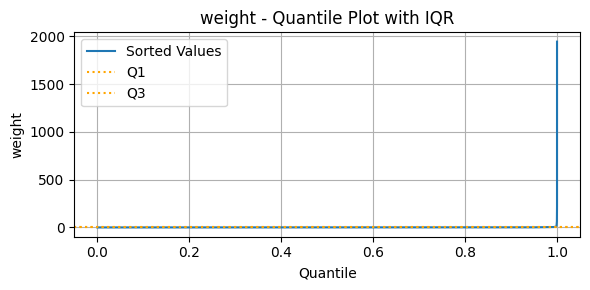


Column: count
Mean: 721.64
Median: 1.00
Std: 1689.68
Min: 1.00
Max: 14497.00
Skewness: 2.93
Kurtosis: 12.42
Pearson Skewness: 1.28
IQR Outliers: 688188
3*STD Outliers: 91373
MAD Outliers: 1243147


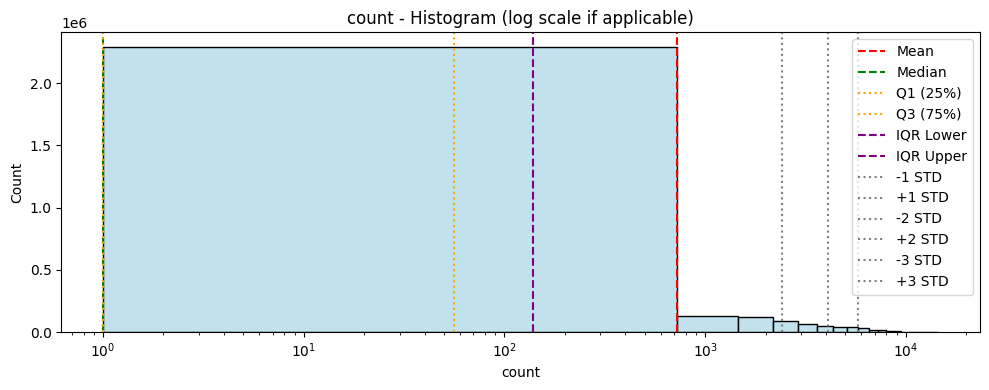

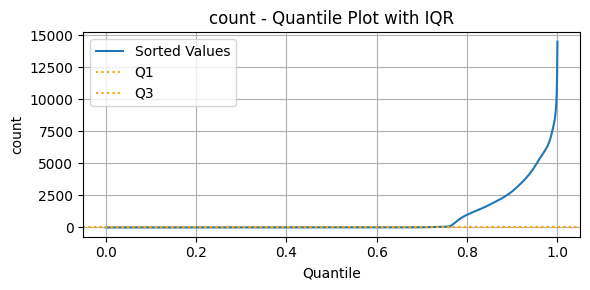


Column: looped
Mean: 238.51
Median: 0.00
Std: 966.32
Min: 0.00
Max: 14496.00
Skewness: 5.52
Kurtosis: 40.24
Pearson Skewness: 0.74
IQR Outliers: 411820
3*STD Outliers: 73748
MAD Outliers: 411820


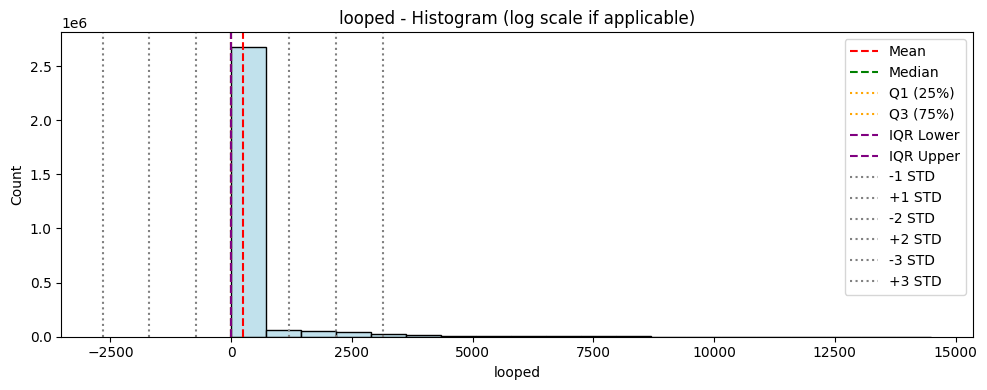

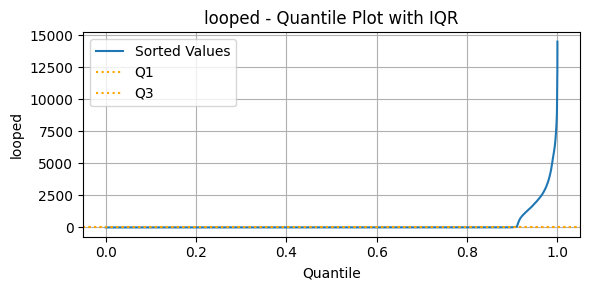


Column: neighbors
Mean: 2.21
Median: 2.00
Std: 17.92
Min: 1.00
Max: 12920.00
Skewness: 293.58
Kurtosis: 171458.60
Pearson Skewness: 0.03
IQR Outliers: 114659
3*STD Outliers: 3090
MAD Outliers: 1058413


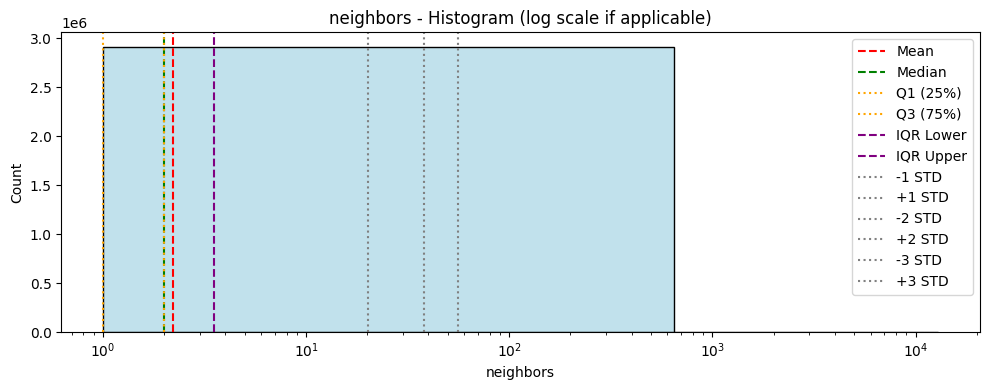

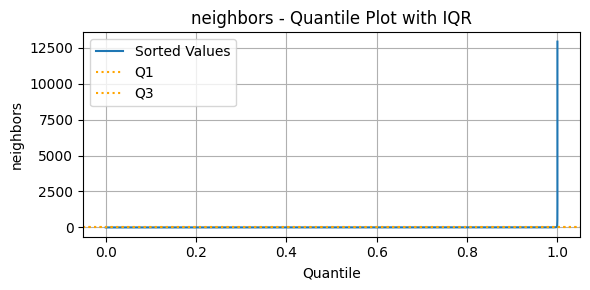


Column: income
Mean: 4464889007.19
Median: 199998518.00
Std: 162685932780.61
Min: 30000000.00
Max: 49964398238996.00
Skewness: 228.37
Kurtosis: 62541.32
Pearson Skewness: 0.08
IQR Outliers: 430677
3*STD Outliers: 2844
MAD Outliers: 872933


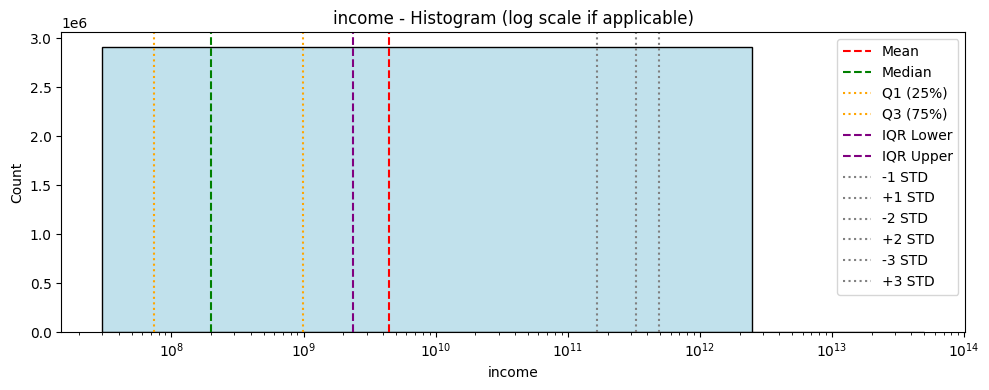

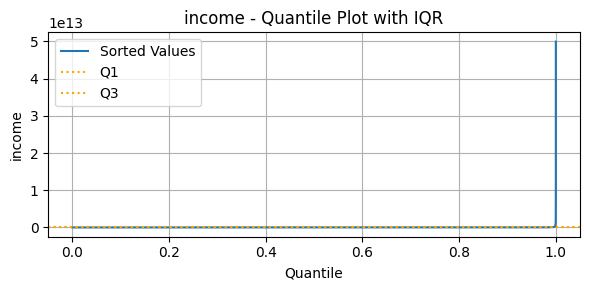

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def describe_distribution_with_log(df, column):
    data = df[column].dropna()
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=0)

    print(f"\nColumn: {column}")
    print(f"Mean: {mean:.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Std: {std:.2f}")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")

    skew = np.sum(((data - mean) / std) ** 3) / n
    kurtosis = np.sum(((data - mean) / std) ** 4) / n
    pearson_skew = 3 * (mean - data.median()) / std

    print(f"Skewness: {skew:.2f}")
    print(f"Kurtosis: {kurtosis:.2f}")
    print(f"Pearson Skewness: {pearson_skew:.2f}")

    quantiles = data.quantile([0.01, 0.25, 0.5, 0.75, 0.99])
    Q1, Q3 = quantiles[0.25], quantiles[0.75]
    IQR = Q3 - Q1
    lower_iqr, upper_iqr = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    iqr_outliers = data[(data < lower_iqr) | (data > upper_iqr)]
    print(f"IQR Outliers: {len(iqr_outliers)}")

    lower_std, upper_std = mean - 3 * std, mean + 3 * std
    std_outliers = data[(data < lower_std) | (data > upper_std)]
    print(f"3*STD Outliers: {len(std_outliers)}")

    median = data.median()
    mad = np.median(np.abs(data - median))
    lower_mad, upper_mad = median - 3 * mad, median + 3 * mad
    mad_outliers = data[(data < lower_mad) | (data > upper_mad)]
    print(f"MAD Outliers: {len(mad_outliers)}")

    # Histogram (log-scaled x-axis)
    plt.figure(figsize=(10, 4))
    sns.histplot(data, bins=20, color='lightblue')

    if (data > 0).all():
        plt.xscale('log')

    plt.axvline(mean, color='red', linestyle='--', label='Mean')
    plt.axvline(median, color='green', linestyle='--', label='Median')
    plt.axvline(Q1, color='orange', linestyle=':', label='Q1 (25%)')
    plt.axvline(Q3, color='orange', linestyle=':', label='Q3 (75%)')
    plt.axvline(lower_iqr, color='purple', linestyle='--', label='IQR Lower')
    plt.axvline(upper_iqr, color='purple', linestyle='--', label='IQR Upper')

    for i in range(1, 4):
        plt.axvline(mean - i * std, color='gray', linestyle=':', label=f'-{i} STD')
        plt.axvline(mean + i * std, color='gray', linestyle=':', label=f'+{i} STD')

    plt.title(f"{column} - Histogram (log scale if applicable)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Quantile Plot
    plt.figure(figsize=(6, 3))
    data_sorted = np.sort(data)
    q_vals = np.linspace(0, 1, len(data_sorted))
    plt.plot(q_vals, data_sorted, label="Sorted Values")
    plt.axhline(Q1, color='orange', linestyle=':', label='Q1')
    plt.axhline(Q3, color='orange', linestyle=':', label='Q3')
    plt.title(f"{column} - Quantile Plot with IQR")
    plt.xlabel("Quantile")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

interested_cols = ['weight', 'count', 'looped', 'neighbors', 'income']

for col in interested_cols:
    describe_distribution_with_log(df, col)


# Explanation:
The above function `describe_distribution` provides a comprehensive summary of each numerical column's statistical properties.
It calculates key metrics such as mean, median, standard deviation, and identifies outliers using three different methods:
- IQR (Interquartile Range)
- 3*STD (Standard Deviation)
- MAD (Median Absolute Deviation)

Visualizations include:
- A histogram with lines marking the mean, median, IQR bounds, and standard deviation thresholds.
- A quantile plot to show the value distribution across percentiles.

These analyses are useful for detecting skewness, abnormal distributions, and potential data entry errors.

However, in some columns we observe that the histogram is very compressed, with most values clustered together
and a few extreme values far away. In such cases, the IQR, STD, and MAD boundaries may not appear clearly in the plot,
or they may visually overlap due to lack of scale separation. This usually happens when:
- The data is heavily skewed or has outliers with very large magnitudes.
- The value range is extremely wide, so visual indicators get pushed to the edges or fall outside the visible range.

In such cases, it’s useful to consider log-scaling the x-axis, so I did that also by optionally applying a logarithmic transformation to the x-axis, which helps to spread out tightly clustered values and bring extreme outliers into view




### Exploring Correlations Before PCA

Before applying PCA, it's good practice to examine whether there are strong linear correlations between numeric features. 
PCA is most useful when features are redundant, for example, if some columns are highly correlated, PCA can transform them into fewer uncorrelated components while retaining most of the variance.

Since our dataset includes several continuous features, i will first compute the correlation matrix to assess whether such redundancy exists and whether PCA would be beneficial for dimensionality reduction or visualization.


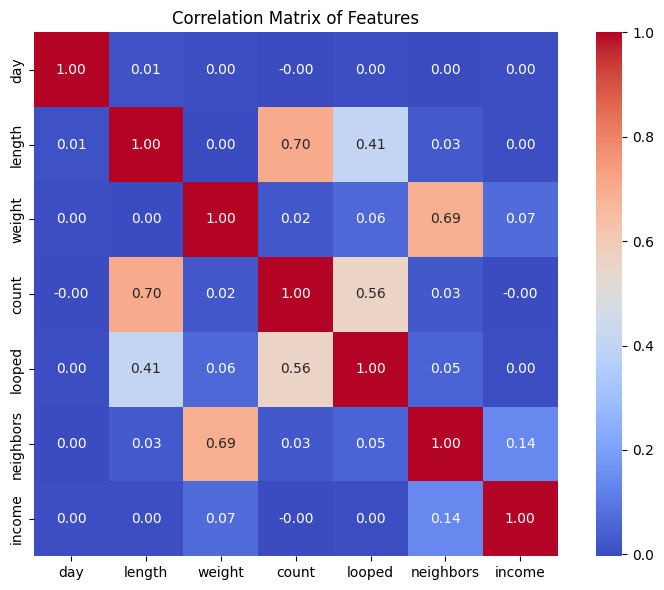

In [7]:
# Compute and visualize correlation matrix
plt.figure(figsize=(8, 6))
corr = df[interested_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()


### Correlation Matrix Insights

The correlation matrix reveals that none of the feature pairs are strongly correlated because no correlation coefficient exceeds the typical threshold of 0.95. 
However, we do observe moderate correlations between some features, for example, `length` and `count` (r ~ 0.70), and `weight` and `neighbors` (r ~ 0.69).

Although these values don't suggest severe multicollinearity, they hint at some overlapping variance in the data. Therefore, we still proceed with PCA — not strictly to reduce dimensionality, but to:
- Explore the structure of the data in a lower dimensional space
- Visualize potential groupings or outliers
- Prepare for potential use in clustering or anomaly detection

Explained variance ratio per component: [0.28140072 0.21811398]
Cumulative variance explained: [0.28140072 0.4995147 ]


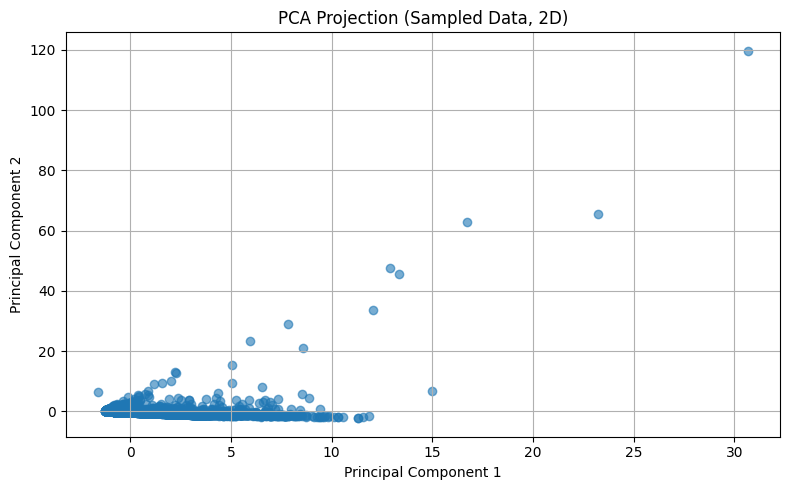

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select numeric columns (excluding 'address' and categorical features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols].dropna()

# Step 2: Take a random sample to avoid memory errors
X_sample = X.sample(n=20000, random_state=42)

# Step 3: Standardize the sample
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Step 4: Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Show explained variance
print("Explained variance ratio per component:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca.explained_variance_ratio_))

# Step 6: Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection (Sampled Data, 2D)")
plt.grid(True)
plt.tight_layout()
plt.show()


### PCA Results Summary

After applying PCA to a sampled subset of the data, we find that the first two principal components capture nearly 50% of the total variance. This indicates that while some structure is preserved, the original features contribute meaningful variance beyond just two dimensions.

Nevertheless, the PCA projection allows us to make tasks such as clustering, classification, or anomaly detection
The transformation also ensures that the new components are uncorrelated, which can help in models that are sensitive to feature redundancy.